In [ ]:
# Import libs
import sys
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.util.environment import get_environment
from docplex.mp.relax_linear import LinearRelaxer
import matplotlib.patches as mpatches
import numpy as np

from datos import *

try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')

def imprimir_solucion(model):
    solution = model.solve()
    model.print_information()
    
    if solution:
        print(f'BENEFICIO:')
        print(f' - ${model.objective_value:.2f}')

        # graficar las variables
        for constraint in model.iter_constraints():
            print(f"Restricción: {constraint.name}")
            print(f"Slack: {constraint.slack_value}")
            print(f"Dual Price: {constraint.dual_value}")
        for var in model.iter_variables():
            print(f"Variable: {var.name}")
            print(f"Valor: {var.solution_value}")
            print(f"Reduced Cost: {var.reduced_cost}")
            
    else:
        print("No se encontro solución.")

def imprimir_graficos(model, servicios, producido , costos, limites):
    # Datos necesarios
    produccion_graf = {servicio: producido[servicio].solution_value for servicio in servicios}
    total = sum(produccion_graf.values())

    fig, ax = plt.subplots()
    bars = ax.bar(produccion_graf.keys(), produccion_graf.values(), color='blue')
    # ax.axhline(y=total, color='r', linestyle='--', label='Total de producción')

    colores = {
        A: '#6b227d',
        B: '#ff6347',
        C: '#008000'
    }

    for servicio in servicios:
        ax.axhline(y=limites[servicio], color=colores[servicio], linestyle='--', label=f"Demanda {servicio}")
    ax.set_ylabel('Producción')
    ax.set_title('Producción con Límite Total')
    ax.legend()

    # Mostrar el valor sobre cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

    costos = {
        "Produccion" : costos["materia_prima"].solution_value,
        "Translado" : costos["translado"].solution_value,
        "Horas Extra" : costos["horas_extra"].solution_value,
        "Capacidad Ociosa": costos["capacidad_ociosa"].solution_value
    }
    total = sum(costos.values())
    porcentaje_costos = {tipo: (valor / total) * 100 for tipo, valor in costos.items() if valor > 0}

    # Gráfico de pastel para representar el porcentaje de cada aceite en el producto final
    plt.figure(figsize=(8, 8))
    plt.pie(porcentaje_costos.values(), labels=porcentaje_costos.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue', 'lightgreen', 'gold', 'lightpink'])
    plt.title('Porcentaje de cada costo respecto del costo total')
    plt.show()

# PROBLEMA ORIGINAL - Papelera Godoy

### POSIBLES HIPOTESIS
1. si me llegan a entrar 7000 cajas, las cuales supera el limite de produccion, entonces no se produce nada, porque no cumple la restriccion -> eso significa que la empresa no trabaja / no toma el pedido ya que no tiene capacidad para producirlo

### Horas Extras:
Como para la produccion de B no tenemos restricciones, a cierto valor de demanda de B, se van a requerir horas extras 

Model: TP: Equipo A SRL (CASO BASE)
 - number of variables: 10
   - binary=0, integer=0, continuous=10
 - number of constraints: 11
   - linear=11
 - parameters: defaults
 - objective: maximize
 - problem type is: LP
BENEFICIO:
 - $1117059.52
Restricción: None
Slack: 260000.0
Dual Price: 0
Restricción: None
Slack: 0
Dual Price: 1.4341666666666666
Restricción: None
Slack: 0
Dual Price: -0.05
Restricción: None
Slack: 0
Dual Price: -0.03333333333333333
Restricción: None
Slack: 0
Dual Price: -1.9714285714285713
Restricción: None
Slack: 0
Dual Price: 10157.142857142857
Restricción: None
Slack: 0
Dual Price: 0.25
Restricción: None
Slack: 0
Dual Price: 0.1875
Restricción: None
Slack: 0
Dual Price: -1.4285714285714286
Restricción: None
Slack: 0
Dual Price: -150.0
Restricción: None
Slack: 260.0
Dual Price: 0
Variable: Producido_Ensobrado
Valor: 240000.0
Reduced Cost: 0
Variable: Cantidad_Cajas_A_Comprar_Para_Ensobrado
Valor: 800.0
Reduced Cost: 0
Variable: Consumo_horas_produccion_de_Ensobrado


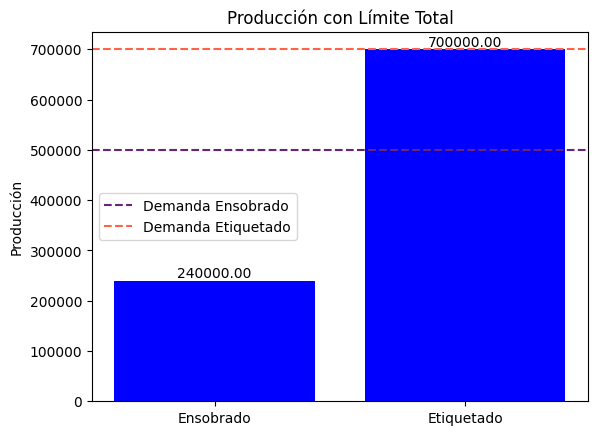

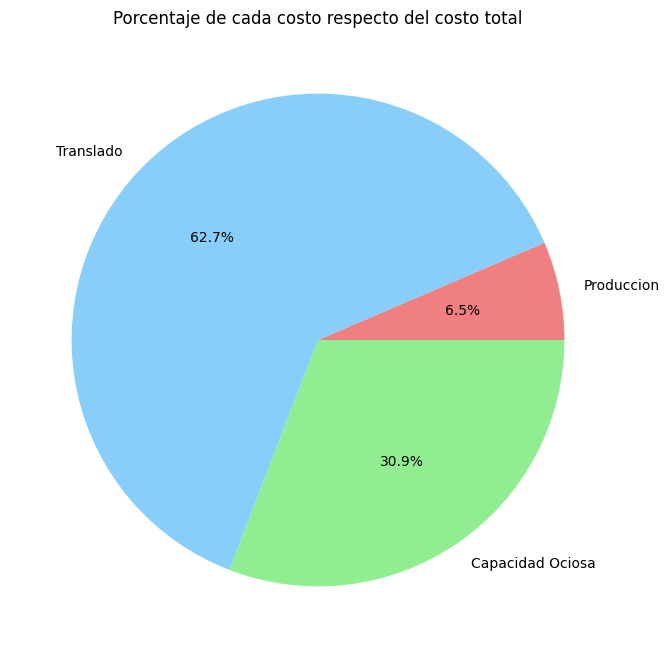

In [7]:
mdl = Model(name="TP: Equipo A SRL (CASO BASE)")

producido = dict()
cantidad_cajas = dict()
horas_produccion_producto = dict()
for servicio in servicios:
    producido[servicio] = mdl.continuous_var(name=f'Producido_{servicio}')
    cantidad_cajas[servicio] = mdl.continuous_var(name=f"Cantidad_Cajas_A_Comprar_Para_{servicio}")
    horas_produccion_producto[servicio] = mdl.continuous_var(name=f"Consumo_horas_produccion_de_{servicio}")
horas_maquina = mdl.continuous_var(name=f"Consumo_horas_maquina")
horas_extra = mdl.continuous_var(name=f"Horas_Extra")
capacidad_ociosa = mdl.continuous_var(name=f"Horas_Sobrantes")
cantidad_translados = mdl.continuous_var(name=f"Cantidad_Translados")

#-- RESTRICCIONES --
#-- DEMANDA MAXIMA --
for servicio in servicios:
    mdl.add_constraint(producido[servicio] <= LIMITES_PRODUCCION[servicio])

#-- CONSUMO RECURSOS --
# Consumo de cajas
for servicio in servicios:
    mdl.add_constraint(CAPACIDAD_CAJA[servicio]*cantidad_cajas[servicio] == producido[servicio])

# Consumo de maquina
mdl.add_constraint(PRODUCCION_MAQUINA[M1]*horas_maquina == producido[A]) # Solo el producto A tiene un proceso de maquina
mdl.add_constraint(horas_maquina <= LIMITE_HORAS_MAQUINA[M1])

# Consumo horas trabajo
for servicio in servicios:
    mdl.add_constraint(PRODUCCION_HORA[servicio]*horas_produccion_producto[servicio] == producido[servicio])
horas_produccion = horas_produccion_producto[A] + horas_produccion_producto[B]
    
# Translado
mdl.add_constraint(CAPACIDAD_TRANSLADO[A]*cantidad_translados == producido[A])

#-- Restricciones horarias --
mdl.add_constraint(PERSONAL_NECESARIO_MAQUINA[M1]*horas_maquina + horas_produccion == LIMITE_HORAS_HOMBRE + horas_extra - capacidad_ociosa)


#-- Max Horas extra --
mdl.add_constraint(horas_extra <= MAX_HORAS_EXTRA_PERSONAL)

ingresos = mdl.sum(PRECIO_VENTA[servicio]*producido[servicio] for servicio in servicios)
costos_materia_prima = mdl.sum(PRECIO_CAJAS*cantidad_cajas[servicio] for servicio in servicios)
costo_horas_extra = horas_extra*PRECIO_HORA_EXTRA
costo_capacidad_ociosa = capacidad_ociosa*PRECIO_CAPACIDAD_OCIOSA
costo_translado = cantidad_translados*PRECIO_TRANSLADO[A]

costos = costos_materia_prima + costo_horas_extra + costo_capacidad_ociosa + costo_translado

beneficio = ingresos - costos
mdl.maximize(beneficio)

# Imprimir la solución
imprimir_solucion(mdl)
costos_totales = {
    "materia_prima": costos_materia_prima,
    "horas_extra": costo_horas_extra,
    "capacidad_ociosa": costo_capacidad_ociosa,
    "translado": costo_translado
}
imprimir_graficos(mdl, servicios, producido, costos_totales, LIMITES_PRODUCCION)

# PROBLEMA 2 (Agregar nuevo producto)

Model: TP: Equipo A SRL (NUEVO PRODUCTO)
 - number of variables: 16
   - binary=0, integer=0, continuous=16
 - number of constraints: 17
   - linear=17
 - parameters: defaults
 - objective: maximize
 - problem type is: LP
BENEFICIO:
 - $1436049.52
Restricción: None
Slack: 260000.0
Dual Price: 0
Restricción: None
Slack: 0
Dual Price: 1.2466666666666666
Restricción: None
Slack: 308000.0
Dual Price: 0
Restricción: None
Slack: 0
Dual Price: -0.05
Restricción: None
Slack: 0
Dual Price: -0.03333333333333333
Restricción: None
Slack: 0
Dual Price: -0.01
Restricción: None
Slack: 0
Dual Price: -1.7214285714285715
Restricción: None
Slack: 0
Dual Price: -2.62
Restricción: None
Slack: 0
Dual Price: 8907.142857142857
Restricción: None
Slack: 0
Dual Price: 10630.0
Restricción: None
Slack: 0
Dual Price: 0
Restricción: None
Slack: 0
Dual Price: 0
Restricción: None
Slack: 0
Dual Price: 1.125
Restricción: None
Slack: 0
Dual Price: -1.4285714285714286
Restricción: None
Slack: 0
Dual Price: -2.0
Restricció

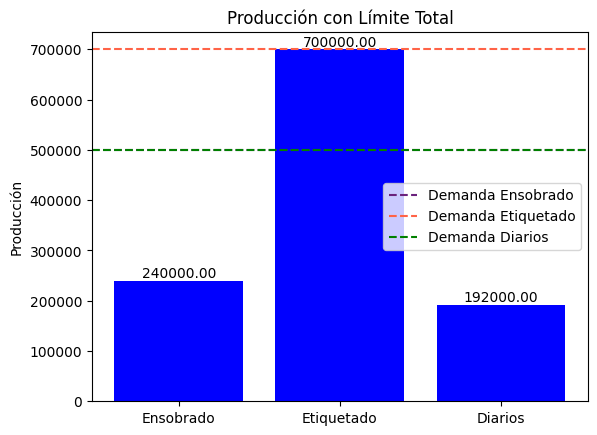

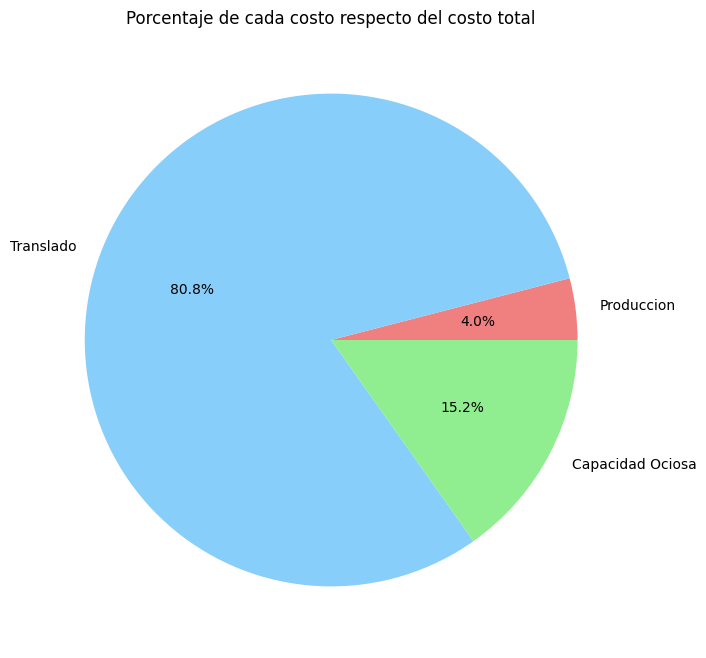

In [ ]:
# Servicios
servicios.append(C)
maquinas.append(M2)

# #-------- MODELO 2 --------

mdl = Model(name="TP: Equipo A SRL (NUEVO PRODUCTO)")

cantidad_tinta = mdl.continuous_var(name=f"Cantidad_tinta_a_comprar_para_diarios")
cantidad_cajas = dict()
producido = dict()
horas_produccion_producto = dict()
horas_maquina = dict()

for servicio in servicios:
    producido[servicio] = mdl.continuous_var(name=f'Producido_{servicio}')
    horas_produccion_producto[servicio] = mdl.continuous_var(name=f"Consumo_horas_produccion_de_{servicio}")
    if servicio != C:
        cantidad_cajas[servicio] = mdl.continuous_var(name=f"Cantidad_Cajas_A_Comprar_Para_{servicio}")

for maquina in maquinas:
    horas_maquina[maquina] = mdl.continuous_var(name=f"Consumo_horas_maquina__{maquina}")

horas_produccion = mdl.continuous_var(name=f"Consumo_horas_produccion")
horas_extra = mdl.continuous_var(name=f"Horas_Extra")
capacidad_ociosa = mdl.continuous_var(name=f"Horas_Sobrantes")
cantidad_translados_sobres = mdl.continuous_var(name=f"Cantidad_Translados_sobres")
cantidad_translados_diarios = mdl.continuous_var(name=f"Cantidad_Translados_diarios")

# #-- RESTRICCIONES --
# #-- DEMANDA MAXIMA --
for servicio in servicios:
    mdl.add_constraint(producido[servicio] <= LIMITES_PRODUCCION[servicio])

# #-- CONSUMO RECURSOS --
# # Consumo de cajas y tinta
for servicio in servicios:
    if servicio == C:
        mdl.add_constraint(cantidad_tinta == producido[servicio] * TINTA_DIARIO)
    else: 
        mdl.add_constraint(CAPACIDAD_CAJA[servicio]*cantidad_cajas[servicio] == producido[servicio])

# # Consumo de maquina
mdl.add_constraint(PRODUCCION_MAQUINA[M1]*horas_maquina[M1] == producido[A]) 
mdl.add_constraint(PRODUCCION_MAQUINA[M2]*horas_maquina[M2] == producido[C])

for maquina in maquinas:
    mdl.add_constraint(horas_maquina[maquina] <= LIMITE_HORAS_MAQUINA[maquina])

# Consumo horas trabajo
for servicio in servicios:
    mdl.add_constraint(PRODUCCION_HORA[servicio]*horas_produccion_producto[servicio] == producido[servicio])
horas_produccion = mdl.sum(horas_produccion_producto[servicio] for servicio in servicios)

# Translado
mdl.add_constraint(CAPACIDAD_TRANSLADO[A]*cantidad_translados_sobres == producido[A])
mdl.add_constraint(CAPACIDAD_TRANSLADO[C]*cantidad_translados_diarios == producido[C])


#-- Restricciones horarias --
suma_horas_maquina = (PERSONAL_NECESARIO_MAQUINA[M1]*horas_maquina[M1]) + (PERSONAL_NECESARIO_MAQUINA[M2]*horas_maquina[M2])
mdl.add_constraint(suma_horas_maquina + horas_produccion == LIMITE_HORAS_HOMBRE + horas_extra - capacidad_ociosa)


#-- Max Horas extra --
mdl.add_constraint(horas_extra <= MAX_HORAS_EXTRA_PERSONAL)

# #-- FUNCIONAL -- 
# # Ingresos
ingresos = mdl.sum(PRECIO_VENTA[servicio]*producido[servicio] for servicio in servicios)

# Costos
costo_materia_prima_sobres = mdl.sum(PRECIO_CAJAS*cantidad_cajas[servicio] for servicio in servicios if servicio != C) 
costo_materia_prima_diarios = PRECIO_TINTA * cantidad_tinta / 1000 
costos_materia_prima = costo_materia_prima_sobres + costo_materia_prima_diarios

costo_horas_extra = horas_extra*PRECIO_HORA_EXTRA
costo_capacidad_ociosa = capacidad_ociosa*PRECIO_CAPACIDAD_OCIOSA

costo_translado = cantidad_translados_sobres*PRECIO_TRANSLADO[A] + cantidad_translados_diarios*PRECIO_TRANSLADO[C]

costos = costos_materia_prima + costo_horas_extra + costo_capacidad_ociosa + costo_translado

beneficio = ingresos - costos
mdl.maximize(beneficio)

# Imprimir la solución
imprimir_solucion(mdl)
costos_totales = {
    "materia_prima": costos_materia_prima,
    "horas_extra": costo_horas_extra,
    "capacidad_ociosa": costo_capacidad_ociosa,
    "translado": costo_translado
}
imprimir_graficos(mdl, servicios, producido, costos_totales, LIMITES_PRODUCCION)

servicios.remove(C)
maquinas.remove(M2)

# PROBLEMA 3 (Control de calidad)

Model: TP: Equipo A SRL (CONTROL DE CALIDAD)
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 13
   - linear=13
 - parameters: defaults
 - objective: maximize
 - problem type is: LP
BENEFICIO:
 - $1189749.52
Restricción: None
Slack: 260000.0
Dual Price: 0
Restricción: None
Slack: 0
Dual Price: 1.6216666666666666
Restricción: None
Slack: 0
Dual Price: -0.05
Restricción: None
Slack: 0
Dual Price: -0.03333333333333333
Restricción: None
Slack: 0
Dual Price: -1.7274285714285713
Restricción: None
Slack: 0
Dual Price: 8937.142857142857
Restricción: None
Slack: 0
Dual Price: 0.30000000000000004
Restricción: None
Slack: 0
Dual Price: 0
Restricción: None
Slack: 0
Dual Price: 0.375
Restricción: None
Slack: 0
Dual Price: -1.4285714285714286
Restricción: None
Slack: 0
Dual Price: -150.0
Restricción: None
Slack: 0
Dual Price: -1.5
Restricción: None
Slack: 260.0
Dual Price: 0
Variable: Producido_Ensobrado
Valor: 240000.0
Reduced Cost: 0
Variable: Cantidad_C

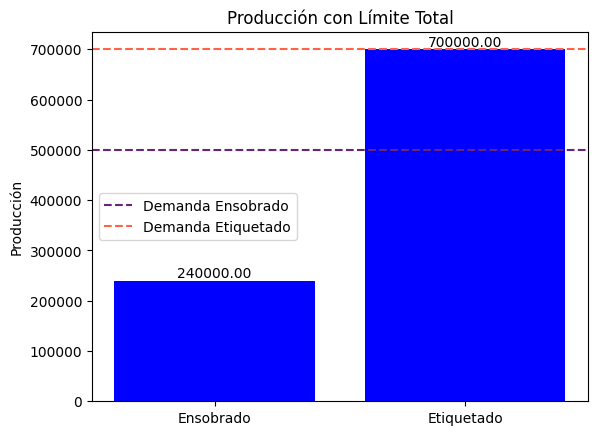

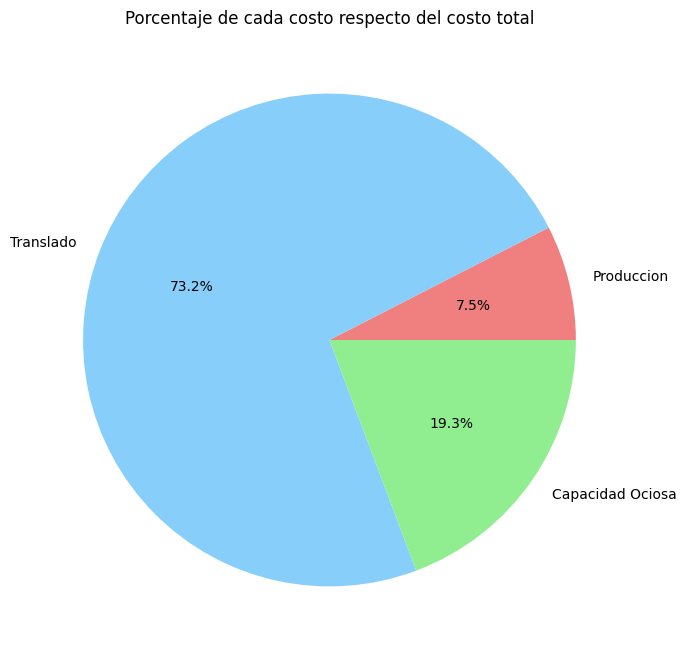

In [9]:
# Reparacion
PORCENTAJE_RECHAZO_MAQUINA = {
    M1: 0.02 #0.02
}
COSTO_REPARACION_SOBRES = 1.2 # 1.2



# --- Modelo 3

mdl = Model(name="TP: Equipo A SRL (CONTROL DE CALIDAD)")

producido = dict()
cantidad_cajas = dict()
horas_produccion_producto = dict()
for servicio in servicios:
    producido[servicio] = mdl.continuous_var(name=f'Producido_{servicio}')
    cantidad_cajas[servicio] = mdl.continuous_var(name=f"Cantidad_Cajas_A_Comprar_Para_{servicio}")
    horas_produccion_producto[servicio] = mdl.continuous_var(name=f"Consumo_horas_produccion_de_{servicio}")

horas_maquina = mdl.continuous_var(name=f"Consumo_horas_maquina")
horas_extra = mdl.continuous_var(name=f"Horas_Extra")
horas_reparacion_sobres = mdl.continuous_var(name=f"consumo_horas_reparacion_sobres")
capacidad_ociosa = mdl.continuous_var(name=f"Horas_Sobrantes")
cantidad_translados = mdl.continuous_var(name=f"Cantidad_Translados")
rechazados_por_maquina = mdl.continuous_var(name=f"cantidad_rechazados_maquina_1")

#-- RESTRICCIONES --
#-- DEMANDA MAXIMA --
for servicio in servicios:
    mdl.add_constraint(producido[servicio] <= LIMITES_PRODUCCION[servicio])

#-- CONSUMO RECURSOS --
# Consumo de cajas
for servicio in servicios:
    mdl.add_constraint(CAPACIDAD_CAJA[servicio]*cantidad_cajas[servicio] == producido[servicio])

# Consumo de maquina
mdl.add_constraint(PRODUCCION_MAQUINA[M1]*horas_maquina == producido[A]) # Solo el producto A tiene un proceso de maquina
mdl.add_constraint(horas_maquina <= LIMITE_HORAS_MAQUINA[M1])
mdl.add_constraint(rechazados_por_maquina == producido[A] * PORCENTAJE_RECHAZO_MAQUINA[M1])

# Consumo horas trabajo
for servicio in servicios:
    mdl.add_constraint(PRODUCCION_HORA[servicio]*horas_produccion_producto[servicio] == producido[servicio])
horas_produccion = mdl.sum(horas_produccion_producto[servicio] for servio in servicios)

# Translado
mdl.add_constraint(CAPACIDAD_TRANSLADO[A]*cantidad_translados == producido[A])

#-- Restricciones horarias --
mdl.add_constraint(PERSONAL_NECESARIO_MAQUINA[M1]*horas_maquina + horas_produccion + horas_reparacion_sobres == LIMITE_HORAS_HOMBRE + horas_extra - capacidad_ociosa)

#-- Rechazo maquinas --
mdl.add_constraint(rechazados_por_maquina == horas_reparacion_sobres * REPARACION_HORA[A])

#-- Max Horas extra --
mdl.add_constraint(horas_extra <= MAX_HORAS_EXTRA_PERSONAL)


ingresos = mdl.sum(PRECIO_VENTA[servicio]*producido[servicio] for servicio in servicios)

costos_materia_prima = mdl.sum(PRECIO_CAJAS*cantidad_cajas[servicio] for servicio in servicios)
costo_horas_extra = horas_extra*PRECIO_HORA_EXTRA
costo_capacidad_ociosa = capacidad_ociosa*PRECIO_CAPACIDAD_OCIOSA
costo_translado = cantidad_translados*PRECIO_TRANSLADO[A]
costo_reparado = rechazados_por_maquina * COSTO_REPARACION_SOBRES

costos = costos_materia_prima + costo_horas_extra + costo_capacidad_ociosa + costo_translado + costo_reparado

beneficio = ingresos - costos
mdl.maximize(beneficio)


# Imprimir la solución
imprimir_solucion(mdl)
costos_totales = {
    "materia_prima": costos_materia_prima,
    "horas_extra": costo_horas_extra,
    "capacidad_ociosa": costo_capacidad_ociosa,
    "translado": costo_translado
}
imprimir_graficos(mdl, servicios, producido, costos_totales, LIMITES_PRODUCCION)